In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
import torch
import torch.nn as nn
from torch.nn import functional as F

# Question 1

In [2]:
url = "https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv"
oasis_data = pd.read_csv(url)
norm_T2 = StandardScaler().fit_transform(oasis_data["T2"].to_numpy().reshape(-1, 1))
oasis_data = oasis_data.assign(norm_T2 = norm_T2)
oasis_data.head()

,FLAIR,PD,T1,T2,FLAIR_10,PD_10,T1_10,T2_10,FLAIR_20,PD_20,T1_20,T2_20,GOLD_Lesions,norm_T2
0,1.143692,1.586219,-0.799859,1.634467,0.437568,0.823800,-0.002059,0.573663,0.279832,0.548341,0.219136,0.298662,0,1.466353
1,1.652552,1.766672,-1.250992,0.921230,0.663037,0.880250,-0.422060,0.542597,0.422182,0.549711,0.061573,0.280972,0,0.534121
2,1.036099,0.262042,-0.858565,-0.058211,-0.044280,-0.308569,0.014766,-0.256075,-0.136532,-0.350905,0.020673,-0.259914,0,-0.746050
3,1.037692,0.011104,-1.228796,-0.470222,-0.013971,-0.000498,-0.395575,-0.221900,0.000807,-0.003085,-0.193249,-0.139284,0,-1.284565
4,1.580589,1.730152,-0.860949,1.245609,0.617957,0.866352,-0.099919,0.384261,0.391133,0.608826,0.071648,0.340601,0,0.958099


In [3]:
fit = smf.logit('GOLD_Lesions ~ norm_T2', data = oasis_data).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.687421
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           GOLD_Lesions   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Tue, 26 Dec 2023   Pseudo R-squ.:                0.008262
Time:                        19:09:36   Log-Likelihood:                -68.742
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                    0.2845
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.201      0.002      0.998      -0.394       0.395
norm_T2        0.2159      0.204      1.061      0.289      -0.183       0.615
==============================================================================
"""

In [4]:
yhat = 1 / (1 + np.exp(-fit.fittedvalues))

In [5]:
n = oasis_data.shape[0]
X = torch.from_numpy(oasis_data["norm_T2"].values).float().unsqueeze(1)
y = torch.from_numpy(oasis_data["GOLD_Lesions"].values).float().unsqueeze(1)
[X.shape, y.shape, [n, 1]]

[torch.Size([100, 1]), torch.Size([100, 1]), [100, 1]]

In [6]:
class LogisticRegression(nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.pipe = nn.Sequential(nn.Linear(1, 1),
                                  nn.Sigmoid())
     def forward(self, x):
        return self.pipe(x)

In [7]:
numEpochs = 1000
lr = 1e-1
model = LogisticRegression()
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

for epoch in range(numEpochs):
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    model.zero_grad()
    loss.backward()
    optimizer.step()

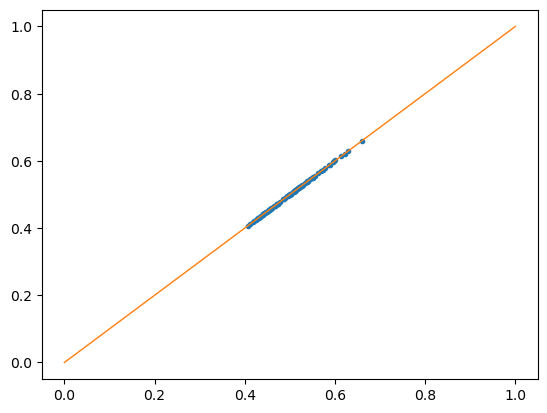

In [8]:
ytest = model(X)
ytest = ytest.detach().numpy().reshape(-1)
plt.plot(yhat, ytest,  ".")
plt.plot([0, 1], [0, 1], linewidth=1)

In [9]:
for param in model.parameters():
  print(param.data)

tensor([[0.2159]])
tensor([0.0005])


Both parameters are the exact same as the StatsModel Logistic Regression. Their results & accuracy are identical. 

# Question 2

### Data Loading

In [10]:
url = "https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv"
diamond_data = pd.read_csv(url)
diamond_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Preprocessing

In [11]:
norm_carat = StandardScaler().fit_transform(diamond_data["carat"].to_numpy().reshape(-1, 1))
diamond_data = diamond_data.assign(norm_carat = norm_carat)

In [12]:
enc1 = OrdinalEncoder(categories = [["Ideal", "Premium", "Very Good", "Good", "Fair"]])
diamond_data["cut"] = enc1.fit_transform(diamond_data["cut"].to_numpy().reshape((-1,1)))

enc2 = OrdinalEncoder(categories = [["D", "E", "F", "G", "H", "I", "J"]])
diamond_data["color"] = enc2.fit_transform(diamond_data["color"].to_numpy().reshape((-1,1)))

enc3 = OrdinalEncoder(categories = [["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1"]])
diamond_data["clarity"] = enc3.fit_transform(diamond_data["clarity"].to_numpy().reshape((-1,1)))

# Training

In [13]:
X = torch.tensor(diamond_data[["norm_carat", "cut", "color", "clarity"]].values, dtype = torch.float)
y = torch.tensor(diamond_data["price"].values, dtype = torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75)
y_train = y_train.unsqueeze(1)
y_test = y_test.unsqueeze(1)

In [14]:
class DiamondRegression(nn.Module):
     def __init__(self):
        super(DiamondRegression, self).__init__()
        self.pipe = torch.nn.Sequential(nn.Linear(4, 3),      
                                        nn.ReLU(),
                                        nn.Linear(3, 2),        
                                        nn.ReLU(),
                                        nn.Linear(2, 1))
     def forward(self, x):
        return self.pipe(x)

In [47]:
numEpochs = 50000
lr = 5e-4
model = DiamondRegression()
loss_fn = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

for epoch in range(numEpochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Testing

In [48]:
# Results
ytest_pred = model(X_test).detach().numpy()
rmse = mean_squared_error(y_test, ytest_pred, squared=False)
print(f'The root mean squared error of the neural network on testing data is {rmse:.02f}')
r2 = r2_score(y_test, ytest_pred, multioutput='variance_weighted')
print(f'The R-squared score of the neural network on testing data is {r2:.02f}')

The root mean squared error of the neural network on testing data is 933.01
The R-squared score of the neural network on testing data is 0.94
